# **Image to Image Translation using Deep Convolutional Generative Adversarial Networks**

# **Configuration of GPU**

In [1]:
! nvidia-smi

Fri Nov  4 08:01:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Download Dataset Form Kaggle**

In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:35<00:00, 46.0MB/s]
100% 1.33G/1.33G [00:35<00:00, 40.4MB/s]


In [7]:
! unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [8]:
import os
import torch
from torch import nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

In [9]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):

    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# **Generator**

In [10]:
class Generator(nn.Module):

  """Generator."""
  def __init__(self, z_dimension=100, hid_channels=64, img_channels=3):
      super().__init__()
      self.z_dimension = z_dimension
      """Initialize model."""
      self.net = nn.Sequential(
          # input(Z) size: (z_dimension) x 1 x 1
          nn.ConvTranspose2d(z_dimension, hid_channels*8, 4, 1, 0, bias=False),
          nn.BatchNorm2d(hid_channels*8),
          nn.ReLU(True),
          # output size: (hid_channels*8) x 4 x 4
          nn.ConvTranspose2d(hid_channels*8, hid_channels*4, 4, 2, 1, bias=False),
          nn.BatchNorm2d(hid_channels*4),
          nn.ReLU(True),
          # output size: (hid_channels*4) x 8 x 8
          nn.ConvTranspose2d(hid_channels*4, hid_channels*2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(hid_channels*2),
          nn.ReLU(True),
          # output size: (hid_channels*2) x 16 x 16
          nn.ConvTranspose2d(hid_channels*2, hid_channels, 4, 2, 1, bias=False),
          nn.BatchNorm2d(hid_channels),
          nn.ReLU(True),
          # output size: (hid_channels) x 32 x 32
          nn.ConvTranspose2d(hid_channels, img_channels, 4, 2, 1, bias=False),
          nn.Tanh()
          # output size: (img_channels) x 64 x 64
      )

  def forward(self, x):
    return self.net(x)

In [11]:
def get_noise(n_samples, z_dimension, device='cpu'):
    return torch.randn(n_samples, z_dimension, device=device)

# Discriminator

In [12]:
class Discriminator(nn.Module):
    """Discriminator."""
    def __init__(self, img_channels=3, hid_channels=64, out_channels=1):
        super().__init__()
        """Initialize model."""
        self.net = nn.Sequential(
            # input(image) size: (img_channels) x 64 x 64
            nn.Conv2d(img_channels, hid_channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # output size: (hid_channels) x 32 x 32
            nn.Conv2d(hid_channels, hid_channels*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hid_channels*2),
            nn.LeakyReLU(0.2, inplace=True),
            # output size: (hid_channels*2) x 16 x 16
            nn.Conv2d(hid_channels*2, hid_channels*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hid_channels*4),
            nn.LeakyReLU(0.2, inplace=True),
            # output size: (hid_channels*4) x 8 x 8
            nn.Conv2d(hid_channels*4, hid_channels*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hid_channels*8),
            nn.LeakyReLU(0.2, inplace=True),
            # output size: (hid_channels*8) x 4 x 4
            nn.Conv2d(hid_channels*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        fx = self.net(x)
        return fx

# **Image Preprocessing**

In [13]:
path = "/content/img_align_celeba/img_align_celeba/"

In [14]:
images_list = os.listdir(path)
len(images_list)

202599

In [15]:
import glob
from  PIL import Image 
from torch.utils.data import Dataset, DataLoader

class CelebA(Dataset):
    """CelebA dataset."""
    def __init__(self, root, transform=None):
        self.root=root
        self.files=sorted(glob.glob(path+"*.jpg"))
        self.transform=transform
        
    def __len__(self,):
        return len(self.files)
    
    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor([0]).long()

In [17]:
noise_dim = 100
batch_size = 128
lr = 0.0002
epochs = 200

device = "cuda"
transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                (0.229, 0.224, 0.225))
])

# **Defining Model**

In [18]:
print('Defining models...')
generator = Generator().to(device)
discriminator = Discriminator().to(device)
# optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
# loss functions
g_criterion = nn.BCELoss().to(device)
d_criterion = nn.BCELoss().to(device)
# dataset
dataset = CelebA(root=path, transform=transforms)
dataset, _ = torch.utils.data.random_split(dataset, [12800,189799])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Defining models...


In [19]:
! pip install progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9632 sha256=c7be7c62ae05839af95b1fed0e0d2681c01caf91b7a5642d8e25f264315c3b0f
  Stored in directory: /root/.cache/pip/wheels/8e/d7/61/498d8e27dc11e9805b01eb3539e2ee344436fc226daeb5fe87
Successfully built progress


# **Model Training**

In [20]:
import math
import time
from progress.bar import IncrementalBar

Start Training...
[Epoch 0/200] [G loss: 9.304] [D loss: 0.344] ETA: 45.092s


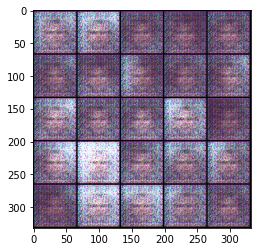

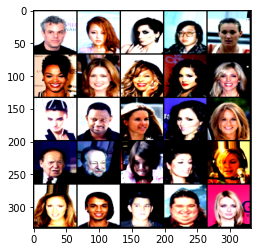

[Epoch 10/200] [G loss: 3.495] [D loss: 0.668] ETA: 32.926s


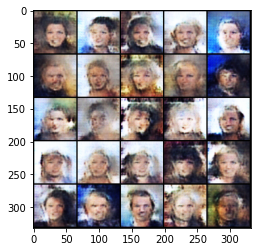

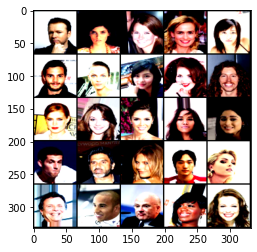

[Epoch 20/200] [G loss: 3.664] [D loss: 0.570] ETA: 32.805s


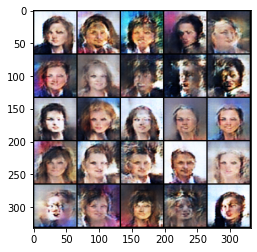

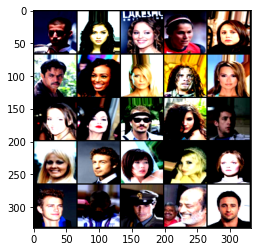

[Epoch 30/200] [G loss: 3.495] [D loss: 0.567] ETA: 32.732s


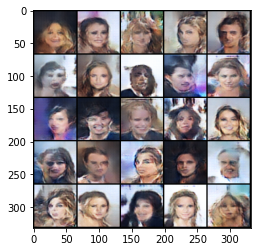

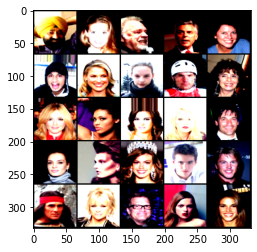

[Epoch 40/200] [G loss: 3.577] [D loss: 0.402] ETA: 32.810s


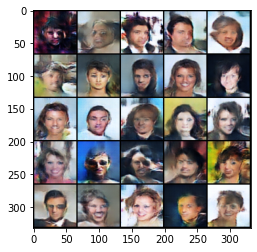

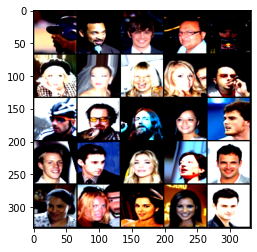

[Epoch 50/200] [G loss: 3.561] [D loss: 0.528] ETA: 32.818s


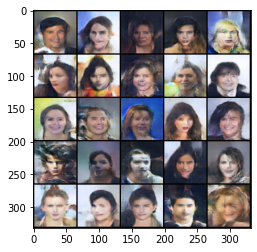

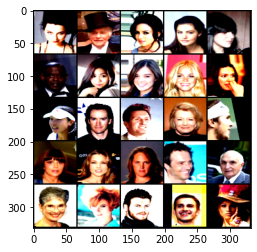

[Epoch 60/200] [G loss: 3.859] [D loss: 0.350] ETA: 32.565s


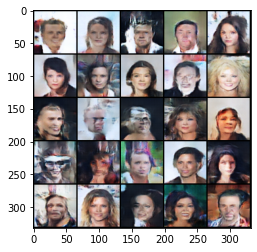

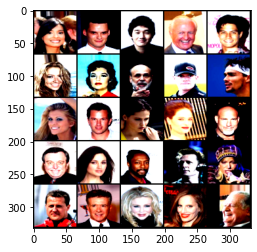

[Epoch 70/200] [G loss: 3.902] [D loss: 0.430] ETA: 32.598s


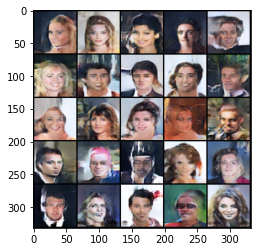

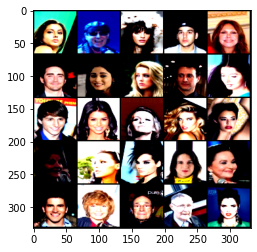

[Epoch 80/200] [G loss: 3.994] [D loss: 0.235] ETA: 32.529s


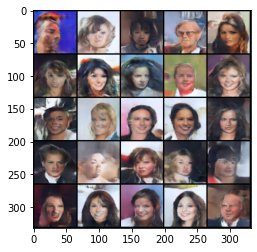

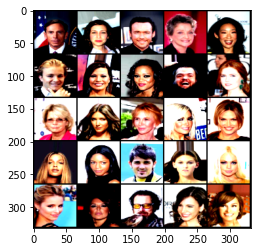

[Epoch 90/200] [G loss: 4.149] [D loss: 0.242] ETA: 32.622s


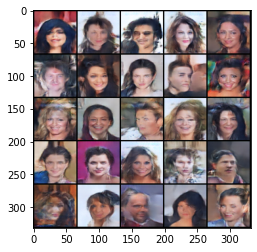

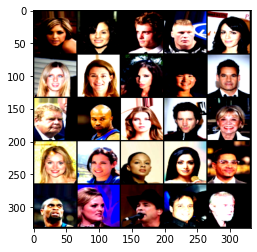

[Epoch 100/200] [G loss: 4.136] [D loss: 0.503] ETA: 33.425s


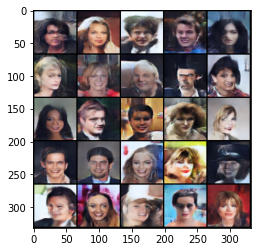

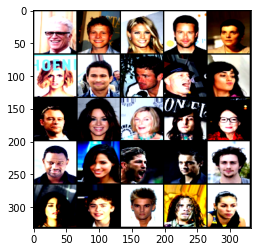

[Epoch 110/200] [G loss: 4.634] [D loss: 0.267] ETA: 32.458s


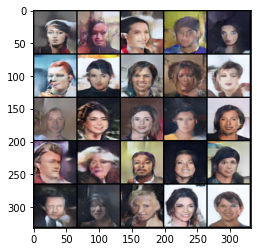

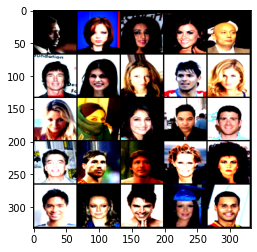

[Epoch 120/200] [G loss: 4.520] [D loss: 0.148] ETA: 36.476s


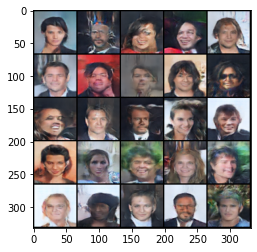

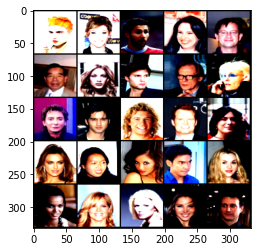

[Epoch 130/200] [G loss: 4.665] [D loss: 0.157] ETA: 35.156s


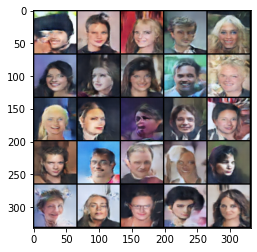

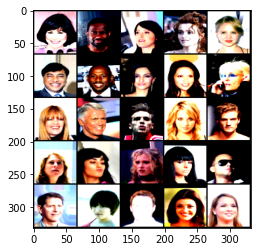

[Epoch 140/200] [G loss: 4.800] [D loss: 0.399] ETA: 33.577s


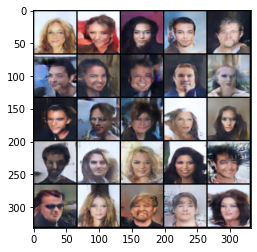

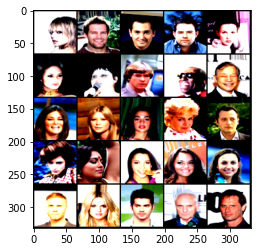

[Epoch 150/200] [G loss: 4.702] [D loss: 0.413] ETA: 33.290s


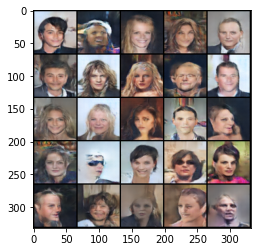

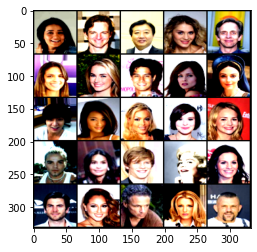

[Epoch 160/200] [G loss: 4.992] [D loss: 0.254] ETA: 32.834s


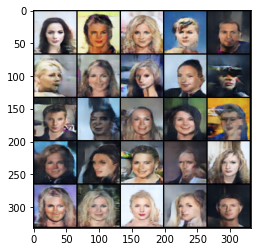

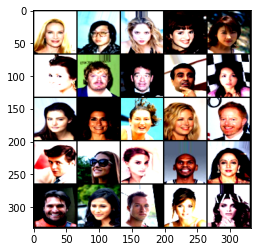

[Epoch 170/200] [G loss: 4.895] [D loss: 0.072] ETA: 33.740s


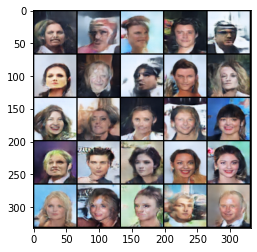

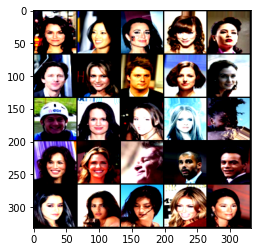

[Epoch 180/200] [G loss: 5.193] [D loss: 0.193] ETA: 34.687s


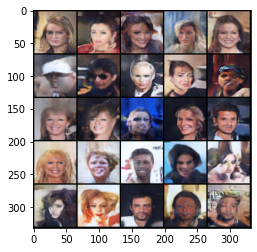

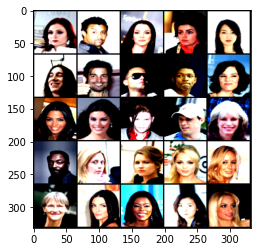

[Epoch 190/200] [G loss: 5.084] [D loss: 0.296] ETA: 32.997s


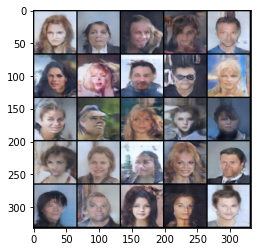

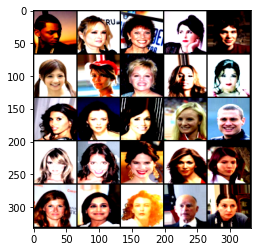

In [21]:
print("Start Training...")
min_loss = math.inf
for epoch in range(epochs):
    de_loss=0.
    ge_loss=0.
    start = time.time()
    bar = IncrementalBar(f'[Epoch {epoch+1}/{epochs}]', max=len(dataloader))
    for real,_ in dataloader:
        real = real.to(device) 
        # Train Discriminator
        discriminator.zero_grad()
        # real loss
        real_pred = discriminator(real)
        real_loss = d_criterion(real_pred, torch.ones_like(real_pred))
        real_loss.backward()
        # generate fake image
        noise = torch.randn(len(real), noise_dim, 1, 1).to(device)
        fake = generator(noise)
        # fake loss
        fake_pred = discriminator(fake.detach())
        fake_loss = d_criterion(fake_pred, torch.zeros_like(fake_pred))
        fake_loss.backward()
        # discriminator loss
        d_loss = real_loss + fake_loss
        # update parameters
        d_optimizer.step()
        
        # Train Generator
        generator.zero_grad()
        # fooling loss
        fake_pred = discriminator(fake)
        g_loss = g_criterion(fake_pred, torch.ones_like(fake_pred))
        g_loss.backward()
        # update parameters
        g_optimizer.step()
        
        de_loss += d_loss.item()
        ge_loss += g_loss.item()
        bar.next()
    bar.finish()  
    g_loss = ge_loss/len(dataloader)
    d_loss = de_loss/len(dataloader)
    end = time.time()
    tm = (end - start)
    
    if min_loss > g_loss:
        min_loss = g_loss
        torch.save(generator.state_dict(), 'generator_celeba.pt')
        torch.save(discriminator.state_dict(), 'discriminator_celeba.pt')
    

    if epoch % 10 ==0:
      print("[Epoch %d/%d] [G loss: %.3f] [D loss: %.3f] ETA: %.3fs" % (epoch, epochs, g_loss, d_loss, tm))
      show_tensor_images(fake)
      show_tensor_images(real)

# Check Model

In [22]:
# Fake image generate by generator 
def test_models(path, model, input, device = "cpu"):
  input = input.to(device)
  model = model.to(device)
  model.load_state_dict(torch.load(path))
  predictions = model(input)
  return predictions

tensor([[[[ 0.3314,  0.7458,  0.7036,  ...,  0.8169,  0.9216,  0.6212],
          [ 0.8055,  0.8174,  0.5700,  ...,  0.8089,  0.8278,  0.9582],
          [ 0.7772,  0.6059,  0.7230,  ...,  0.9369,  0.7907,  0.8596],
          ...,
          [ 0.8112,  0.6965,  0.5917,  ..., -0.6519, -0.2561, -0.1097],
          [ 0.7451,  0.6726,  0.7565,  ..., -0.3659, -0.3201, -0.4000],
          [ 0.4915,  0.8538,  0.8255,  ..., -0.2028, -0.1498, -0.3174]],

         [[ 0.4146,  0.7835,  0.7262,  ...,  0.9741,  0.8956,  0.7488],
          [ 0.8166,  0.8878,  0.9150,  ...,  0.9042,  0.9365,  0.8654],
          [ 0.7613,  0.9675,  0.8044,  ...,  0.9445,  0.9910,  0.8340],
          ...,
          [ 0.7654,  0.3196,  0.8323,  ..., -0.5351, -0.3926, -0.4401],
          [ 0.8483,  0.5368,  0.6167,  ..., -0.3681, -0.3901, -0.3530],
          [ 0.3705,  0.2800,  0.2122,  ..., -0.4939, -0.5716, -0.6084]],

         [[ 0.6833,  0.9465,  0.9146,  ...,  0.9981,  0.9927,  0.8116],
          [ 0.8587,  0.9936,  

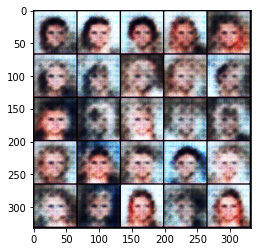

In [23]:
model_path = "/content/generator_celeba.pt"
inputs = torch.randn(batch_size, 100, 1, 1).to(device)
predictions_g = test_models(model_path, Generator(), inputs)
print(predictions_g)
show_tensor_images(predictions_g)

In [24]:
predictions_g.shape

torch.Size([128, 3, 64, 64])

In [25]:
model_path = "/content/discriminator_celeba.pt"
inputs = torch.randn(batch_size, 100, 1, 1).to(device)
predictions_d = test_models(model_path, Discriminator(), predictions_g)
print(predictions_d)


tensor([[[[0.6787]]],


        [[[0.7013]]],


        [[[0.5660]]],


        [[[0.4411]]],


        [[[0.0819]]],


        [[[0.4902]]],


        [[[0.6573]]],


        [[[0.1301]]],


        [[[0.3814]]],


        [[[0.7424]]],


        [[[0.1221]]],


        [[[0.2442]]],


        [[[0.4131]]],


        [[[0.5663]]],


        [[[0.1281]]],


        [[[0.3449]]],


        [[[0.0902]]],


        [[[0.4895]]],


        [[[0.5735]]],


        [[[0.7526]]],


        [[[0.2108]]],


        [[[0.1333]]],


        [[[0.3501]]],


        [[[0.5821]]],


        [[[0.0994]]],


        [[[0.4410]]],


        [[[0.7544]]],


        [[[0.1167]]],


        [[[0.0990]]],


        [[[0.4895]]],


        [[[0.4505]]],


        [[[0.2708]]],


        [[[0.5501]]],


        [[[0.4181]]],


        [[[0.7109]]],


        [[[0.1098]]],


        [[[0.7218]]],


        [[[0.7753]]],


        [[[0.1548]]],


        [[[0.3595]]],


        [[[0.7128]]],


        [[[0.155